In [9]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN

from util import convert_feature_into_cyclic

def preprocess(data):
    data['Year'] = data['DateTime'].dt.year
    data['Month'] = data['DateTime'].dt.month
    data['Day'] = data['DateTime'].dt.day
    data['Weekday'] = data['DateTime'].dt.weekday
    print(f'Number of years: {data['Year'].max() - data['Year'].min() + 1}')
    convert_feature_into_cyclic(data, 'Year', 11)
    convert_feature_into_cyclic(data, 'Month', 12)
    convert_feature_into_cyclic(data, 'Day', 31)
    convert_feature_into_cyclic(data, 'Weekday', 7)
    data.drop(columns=['Volume', 'Open', 'High', 'Low', 'DateTime', 'Year', 'Month', 'Day', 'Weekday'], inplace=True)
    return data

# Read in the data

raw_data = pd.read_csv('../csvs/apple.csv')

raw_data = raw_data.replace('\$', '', regex=True)
raw_data['Close/Last'] = raw_data['Close/Last'].astype(float)
raw_data['Volume'] = raw_data['Volume'].astype(int)
raw_data['Open'] = raw_data['Open'].astype(float)
raw_data['High'] = raw_data['High'].astype(float)
raw_data['Low'] = raw_data['Low'].astype(float)
raw_data['DateTime'] = pd.to_datetime(raw_data['Date'])
raw_data = raw_data.sort_values(by='DateTime')
raw_data.rename(columns={'Close/Last': 'ClosingPrice'}, inplace=True)
raw_data.drop(columns=['Date'], inplace=True)

split_index = int(len(raw_data) * 0.7)
raw_train = raw_data[:split_index]
raw_test = raw_data[split_index:]


raw_data.head(n=10)

<>:28: SyntaxWarning: invalid escape sequence '\$'
<>:28: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_13373/2429574012.py:28: SyntaxWarning: invalid escape sequence '\$'
  raw_data = raw_data.replace('\$', '', regex=True)


,ClosingPrice,Volume,Open,High,Low,DateTime
2513,28.36,295964000,28.05,28.57,27.97,2015-09-18
2512,28.80,186376880,28.42,28.84,28.41,2015-09-21
2511,28.35,201112120,28.34,28.55,28.13,2015-09-22
2510,28.58,142713440,28.41,28.68,28.32,2015-09-23
2509,28.75,200246320,28.31,28.88,28.09,2015-09-24
2508,28.68,224022200,29.11,29.17,28.50,2015-09-25
2507,28.11,207447960,28.46,28.64,28.11,2015-09-28
2506,27.27,292921120,28.21,28.38,26.96,2015-09-29
2505,27.57,265203720,27.54,27.89,27.18,2015-09-30
2504,27.39,255397880,27.27,27.41,26.83,2015-10-01


In [4]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)
descriptions = raw_data.drop(columns=['DateTime']).describe()
descriptions.round(2).to_csv('../csv-descriptions/apple-raw-data-description.csv')
descriptions

,ClosingPrice,Volume,Open,High,Low
count,2514.00,2514.00,2514.00,2514.00,2514.00
mean,109.62,105418074.88,109.51,110.71,108.41
std,69.57,59207298.71,69.50,70.25,68.81
min,22.59,23234710.00,22.50,22.92,22.37
25%,42.77,64982090.00,42.80,43.16,42.43
50%,114.97,91549805.00,114.67,116.06,112.84
75%,170.11,128883650.00,170.08,171.92,168.78
max,259.02,532236000.00,258.19,260.10,257.63


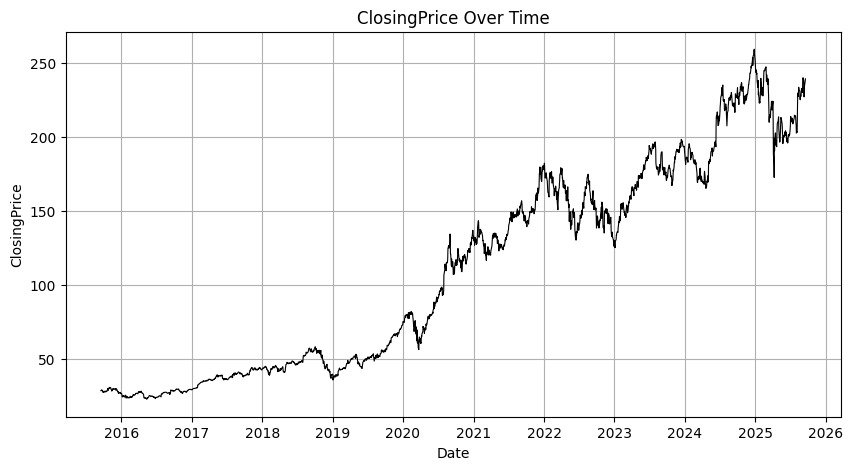

In [80]:
# Display some graphs

from util import plot_feature_over_time

plot_feature_over_time(raw_data, 'ClosingPrice', save_path='../images/apple-closing-price-over-time.pdf', dates=raw_data['DateTime'])


In [11]:
preprocessed_train = preprocess(raw_train.copy())

Number of years: 8


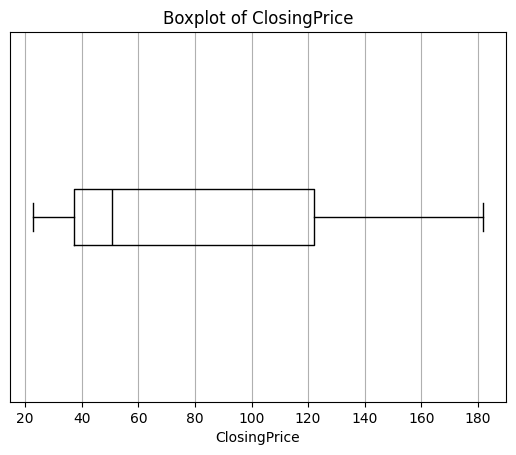

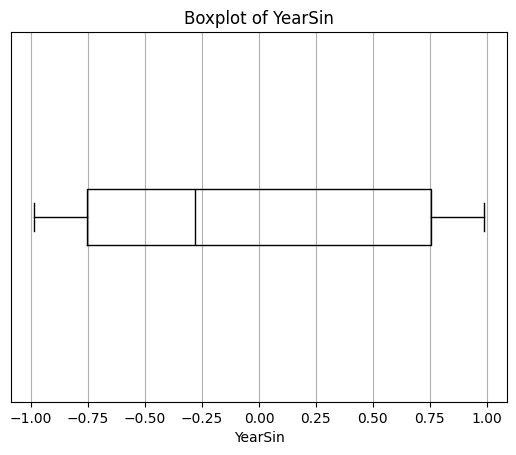

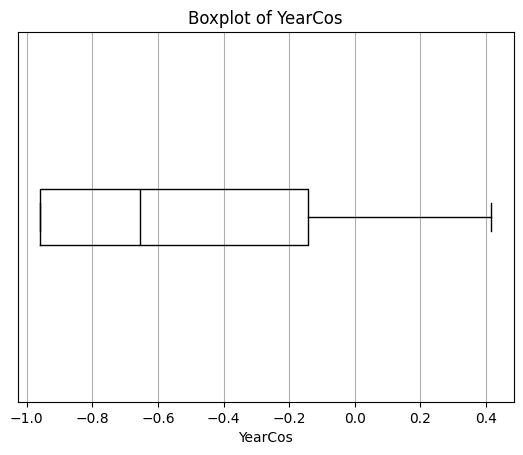

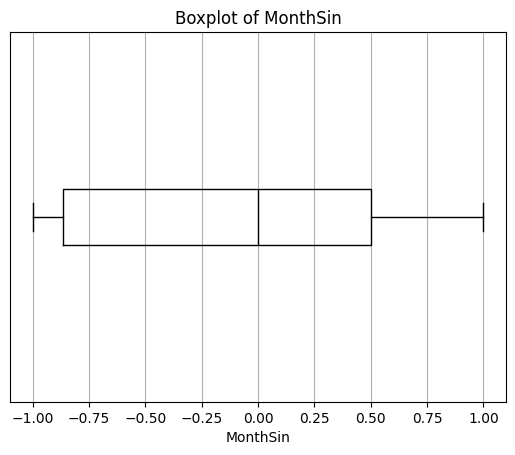

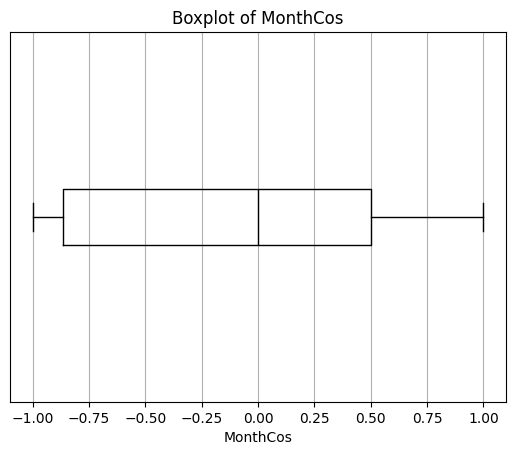

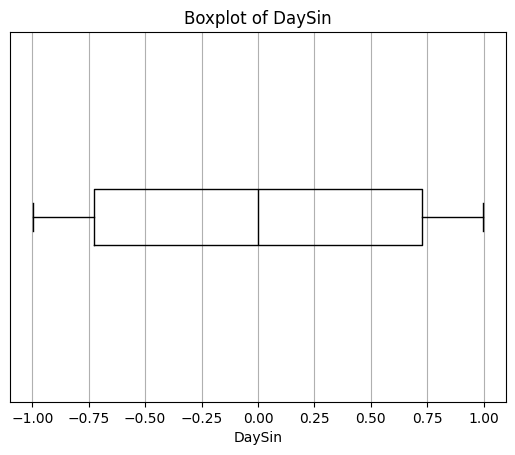

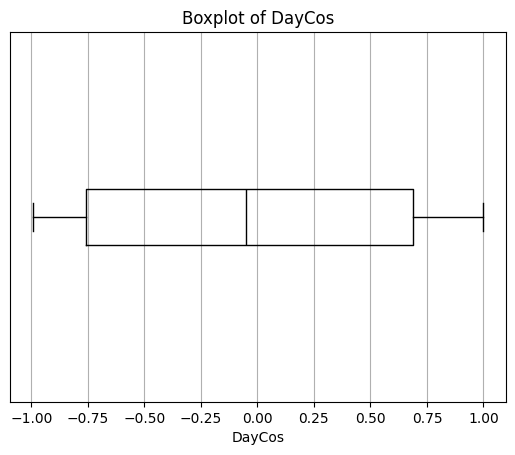

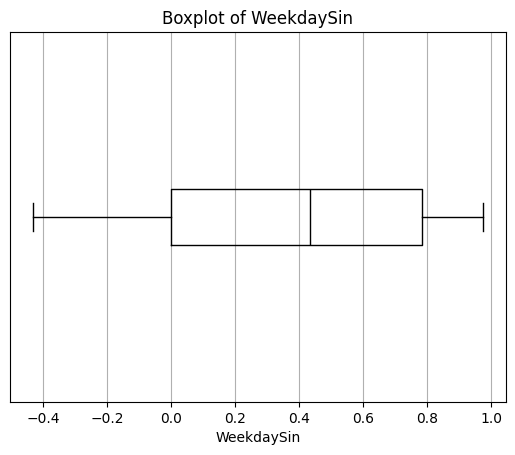

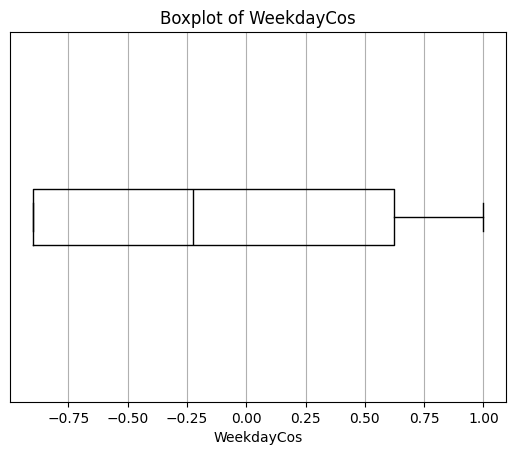

In [13]:
# Statistics of data

from util import plot_boxplot_of_feature
for feature in preprocessed_train.columns:
    plot_boxplot_of_feature(preprocessed_train, feature)


(1759, 8)
(1759,)
(1696, 64, 8)
(1696,)
Train indices from 0 to 191 and validation indices from 192 to 379
Epoch [1/150], Loss: 658.5289, Validation Loss: 1134.2084
Epoch [2/150], Loss: 647.5190, Validation Loss: 1123.0301
Epoch [3/150], Loss: 634.9912, Validation Loss: 1106.4027
Epoch [4/150], Loss: 618.0312, Validation Loss: 1080.6078
Epoch [5/150], Loss: 597.4753, Validation Loss: 1044.6586
Epoch [6/150], Loss: 568.2898, Validation Loss: 1004.2888
Epoch [7/150], Loss: 536.8434, Validation Loss: 967.2565
Epoch [8/150], Loss: 514.7701, Validation Loss: 935.5182
Epoch [9/150], Loss: 494.1235, Validation Loss: 907.5475
Epoch [10/150], Loss: 471.7299, Validation Loss: 881.9641
Epoch [11/150], Loss: 450.8577, Validation Loss: 857.8611
Epoch [12/150], Loss: 436.0954, Validation Loss: 834.7245
Epoch [13/150], Loss: 419.3421, Validation Loss: 812.2770
Epoch [14/150], Loss: 403.9776, Validation Loss: 790.3943
Epoch [15/150], Loss: 388.9621, Validation Loss: 769.0129
Epoch [16/150], Loss: 374.

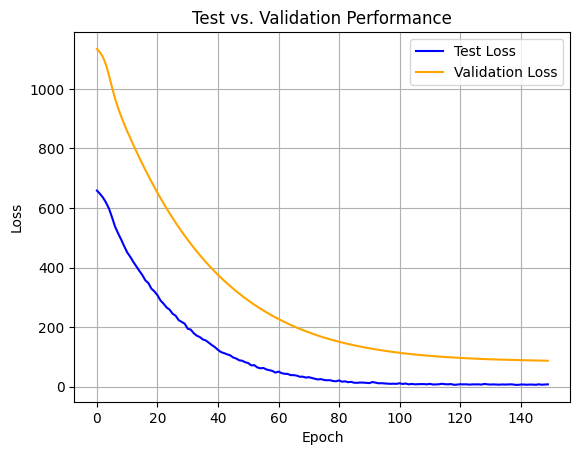

Train indices from 0 to 379 and validation indices from 380 to 567
Epoch [1/150], Loss: 38.8020, Validation Loss: 272.8419
Epoch [2/150], Loss: 35.8753, Validation Loss: 262.7442
Epoch [3/150], Loss: 35.9916, Validation Loss: 252.7154
Epoch [4/150], Loss: 36.5069, Validation Loss: 243.1717
Epoch [5/150], Loss: 33.1288, Validation Loss: 234.2027
Epoch [6/150], Loss: 31.2621, Validation Loss: 225.8122
Epoch [7/150], Loss: 30.4252, Validation Loss: 217.9654
Epoch [8/150], Loss: 28.6833, Validation Loss: 210.8240
Epoch [9/150], Loss: 30.3516, Validation Loss: 204.3593
Epoch [10/150], Loss: 26.9000, Validation Loss: 198.6685
Epoch [11/150], Loss: 27.8635, Validation Loss: 193.5120
Epoch [12/150], Loss: 29.7990, Validation Loss: 189.0689
Epoch [13/150], Loss: 26.8234, Validation Loss: 185.2614
Epoch [14/150], Loss: 27.2584, Validation Loss: 182.0705
Epoch [15/150], Loss: 27.6586, Validation Loss: 179.3973
Epoch [16/150], Loss: 26.4073, Validation Loss: 177.0967
Epoch [17/150], Loss: 26.3863,

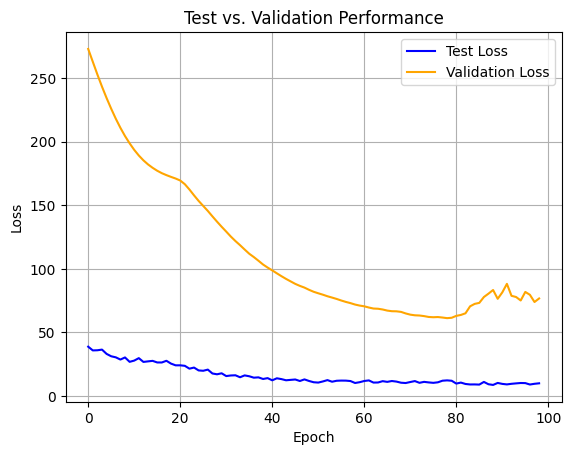

Train indices from 0 to 567 and validation indices from 568 to 755
Epoch [1/150], Loss: 155.4014, Validation Loss: 237.3406
Epoch [2/150], Loss: 60.0691, Validation Loss: 219.9554
Epoch [3/150], Loss: 31.6270, Validation Loss: 204.5546
Epoch [4/150], Loss: 24.9493, Validation Loss: 191.6211
Epoch [5/150], Loss: 27.4299, Validation Loss: 181.4826
Epoch [6/150], Loss: 29.2833, Validation Loss: 173.6055
Epoch [7/150], Loss: 22.2682, Validation Loss: 166.9309
Epoch [8/150], Loss: 24.3297, Validation Loss: 160.9084
Epoch [9/150], Loss: 21.1449, Validation Loss: 154.6929
Epoch [10/150], Loss: 21.7948, Validation Loss: 148.3277
Epoch [11/150], Loss: 22.0219, Validation Loss: 142.4115
Epoch [12/150], Loss: 21.2483, Validation Loss: 136.9266
Epoch [13/150], Loss: 21.6482, Validation Loss: 132.2463
Epoch [14/150], Loss: 18.2085, Validation Loss: 127.8734
Epoch [15/150], Loss: 18.4318, Validation Loss: 123.9572
Epoch [16/150], Loss: 20.0694, Validation Loss: 120.0645
Epoch [17/150], Loss: 16.2048

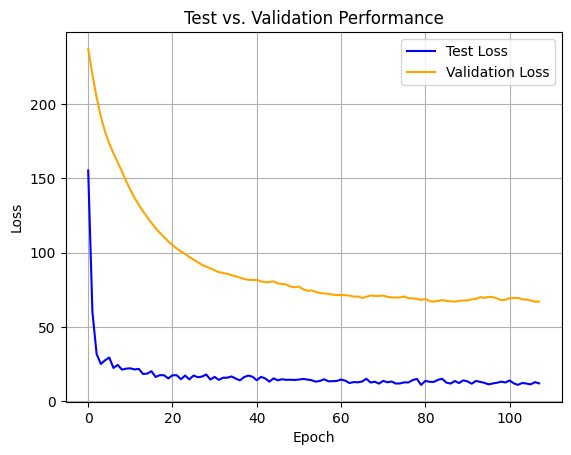

Train indices from 0 to 755 and validation indices from 756 to 943
Epoch [1/150], Loss: 48.1767, Validation Loss: 53.2732
Epoch [2/150], Loss: 45.3902, Validation Loss: 46.0903
Epoch [3/150], Loss: 47.7844, Validation Loss: 45.5009
Epoch [4/150], Loss: 41.8307, Validation Loss: 46.0169
Epoch [5/150], Loss: 38.7103, Validation Loss: 44.0629
Epoch [6/150], Loss: 32.0101, Validation Loss: 39.9876
Epoch [7/150], Loss: 27.4486, Validation Loss: 36.4610
Epoch [8/150], Loss: 26.0732, Validation Loss: 33.7755
Epoch [9/150], Loss: 28.8118, Validation Loss: 31.7304
Epoch [10/150], Loss: 23.1757, Validation Loss: 30.1505
Epoch [11/150], Loss: 25.6389, Validation Loss: 29.3453
Epoch [12/150], Loss: 24.8236, Validation Loss: 28.4603
Epoch [13/150], Loss: 26.4170, Validation Loss: 27.6714
Epoch [14/150], Loss: 24.1012, Validation Loss: 27.0337
Epoch [15/150], Loss: 24.2058, Validation Loss: 26.4729
Epoch [16/150], Loss: 20.6320, Validation Loss: 25.7877
Epoch [17/150], Loss: 21.0275, Validation Loss

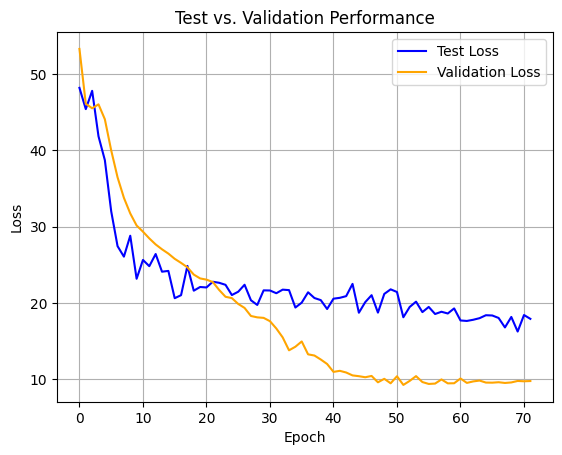

Train indices from 0 to 943 and validation indices from 944 to 1131
Epoch [1/150], Loss: 22.3116, Validation Loss: 612.5438
Epoch [2/150], Loss: 19.3647, Validation Loss: 615.0144
Epoch [3/150], Loss: 21.9458, Validation Loss: 649.9416
Epoch [4/150], Loss: 19.7335, Validation Loss: 623.1279
Epoch [5/150], Loss: 21.2394, Validation Loss: 641.4612
Epoch [6/150], Loss: 21.1923, Validation Loss: 580.8951
Epoch [7/150], Loss: 21.3388, Validation Loss: 655.4954
Epoch [8/150], Loss: 24.2170, Validation Loss: 609.3229
Epoch [9/150], Loss: 24.1466, Validation Loss: 673.3156
Epoch [10/150], Loss: 21.9697, Validation Loss: 628.7582
Epoch [11/150], Loss: 20.1955, Validation Loss: 602.1372
Epoch [12/150], Loss: 22.2692, Validation Loss: 634.4890
Epoch [13/150], Loss: 19.7131, Validation Loss: 651.8505
Epoch [14/150], Loss: 18.6979, Validation Loss: 660.9769
Epoch [15/150], Loss: 19.7086, Validation Loss: 654.9030
Epoch [16/150], Loss: 20.7572, Validation Loss: 672.8334
Epoch [17/150], Loss: 20.5887

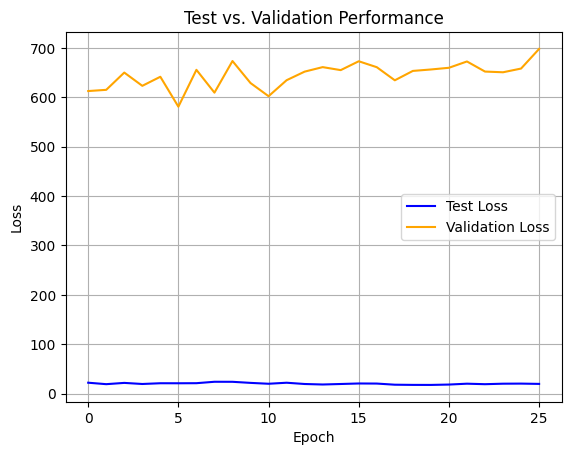

Train indices from 0 to 1131 and validation indices from 1132 to 1319
Epoch [1/150], Loss: 132.5042, Validation Loss: 5164.0842
Epoch [2/150], Loss: 142.5504, Validation Loss: 5064.8068
Epoch [3/150], Loss: 126.2713, Validation Loss: 5096.8652
Epoch [4/150], Loss: 108.8125, Validation Loss: 4960.4296
Epoch [5/150], Loss: 103.9850, Validation Loss: 4829.9502
Epoch [6/150], Loss: 102.8786, Validation Loss: 4777.7534
Epoch [7/150], Loss: 97.8034, Validation Loss: 4748.6166
Epoch [8/150], Loss: 103.1983, Validation Loss: 4682.5696
Epoch [9/150], Loss: 98.2344, Validation Loss: 4657.0800
Epoch [10/150], Loss: 95.1839, Validation Loss: 4623.2129
Epoch [11/150], Loss: 93.4336, Validation Loss: 4578.4078
Epoch [12/150], Loss: 92.2723, Validation Loss: 4536.2421
Epoch [13/150], Loss: 90.8772, Validation Loss: 4495.7167
Epoch [14/150], Loss: 89.8848, Validation Loss: 4451.5109
Epoch [15/150], Loss: 90.1576, Validation Loss: 4430.6787
Epoch [16/150], Loss: 89.5914, Validation Loss: 4373.2852
Epoc

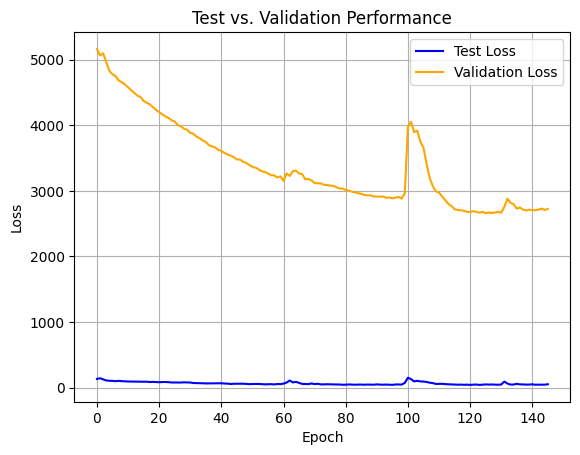

Train indices from 0 to 1319 and validation indices from 1320 to 1507
Epoch [1/150], Loss: 676.8718, Validation Loss: 6140.5156
Epoch [2/150], Loss: 593.0224, Validation Loss: 5574.3630
Epoch [3/150], Loss: 525.1263, Validation Loss: 5321.9248
Epoch [4/150], Loss: 518.6884, Validation Loss: 5168.2567
Epoch [5/150], Loss: 537.7556, Validation Loss: 5069.9911
Epoch [6/150], Loss: 502.6652, Validation Loss: 4965.5176
Epoch [7/150], Loss: 486.9539, Validation Loss: 4842.5297
Epoch [8/150], Loss: 484.9802, Validation Loss: 4736.1582
Epoch [9/150], Loss: 469.9051, Validation Loss: 4636.5486
Epoch [10/150], Loss: 467.4318, Validation Loss: 4540.4725
Epoch [11/150], Loss: 452.2634, Validation Loss: 4440.7385
Epoch [12/150], Loss: 427.6085, Validation Loss: 4351.2992
Epoch [13/150], Loss: 431.0520, Validation Loss: 4264.2762
Epoch [14/150], Loss: 431.9453, Validation Loss: 4180.3059
Epoch [15/150], Loss: 423.0370, Validation Loss: 4099.2614
Epoch [16/150], Loss: 403.9537, Validation Loss: 4021.

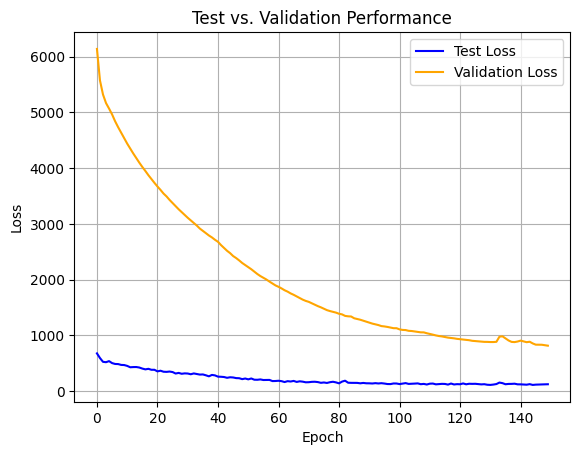

Train indices from 0 to 1507 and validation indices from 1508 to 1695
Epoch [1/150], Loss: 579.2336, Validation Loss: 1968.4866
Epoch [2/150], Loss: 260.0620, Validation Loss: 1782.5212
Epoch [3/150], Loss: 274.6240, Validation Loss: 1761.6061
Epoch [4/150], Loss: 253.6515, Validation Loss: 1721.1099
Epoch [5/150], Loss: 240.9735, Validation Loss: 1676.1943
Epoch [6/150], Loss: 218.6764, Validation Loss: 1648.5115
Epoch [7/150], Loss: 196.0887, Validation Loss: 1597.2510
Epoch [8/150], Loss: 180.4709, Validation Loss: 1561.2393
Epoch [9/150], Loss: 201.1276, Validation Loss: 1524.9780
Epoch [10/150], Loss: 195.8301, Validation Loss: 1495.8901
Epoch [11/150], Loss: 194.4483, Validation Loss: 1465.5002
Epoch [12/150], Loss: 195.9471, Validation Loss: 1436.5882
Epoch [13/150], Loss: 184.5954, Validation Loss: 1408.4070
Epoch [14/150], Loss: 178.9425, Validation Loss: 1387.8128
Epoch [15/150], Loss: 184.7815, Validation Loss: 1354.9523
Epoch [16/150], Loss: 187.7375, Validation Loss: 1341.

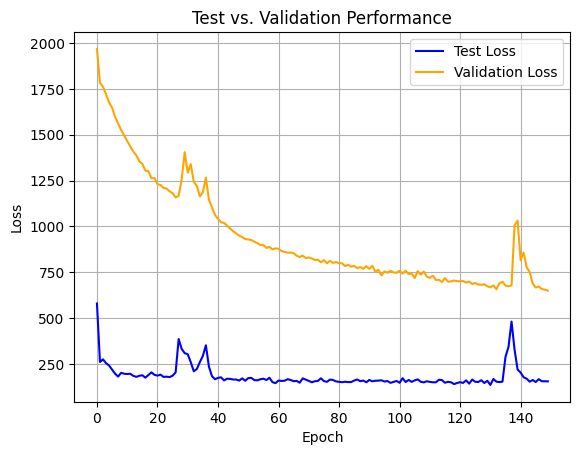

In [ ]:
from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

elman_model_h32 = ElmanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.1)

apple_elman_h32_results = training(model=elman_model_h32,
                             data=preprocessed_train,
                             batch_size=128,
                             optimizer_learning_rate=0.005,
                             optimizer_weight_decay=1e-5,
                             target_feature_name='ClosingPrice',
                             model_name='ElmanRNN_h32_apple',
                             splits=8,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=150)

In [1]:
import pickle

In [ ]:
pickle.dump(apple_elman_h32_results, open('../pickles/apple-elman-h32-results.pkl', 'wb'))

In [2]:
apple_elman_h32_results = pickle.load(open('../pickles/apple-elman-h32-results.pkl', 'rb'))

(1759, 8)
(1759,)
(1696, 64, 8)
(1696,)
Train indices from 0 to 191 and validation indices from 192 to 379
Epoch [1/150], Loss: 653.8163, Validation Loss: 1136.1184
Epoch [2/150], Loss: 638.4342, Validation Loss: 1093.4427
Epoch [3/150], Loss: 603.4167, Validation Loss: 1046.2482
Epoch [4/150], Loss: 568.6206, Validation Loss: 1005.7210
Epoch [5/150], Loss: 541.0217, Validation Loss: 971.4947
Epoch [6/150], Loss: 514.8303, Validation Loss: 942.2308
Epoch [7/150], Loss: 495.8221, Validation Loss: 916.4969
Epoch [8/150], Loss: 477.3266, Validation Loss: 893.0522
Epoch [9/150], Loss: 460.7516, Validation Loss: 870.9662
Epoch [10/150], Loss: 442.6652, Validation Loss: 849.6858
Epoch [11/150], Loss: 430.6963, Validation Loss: 828.9652
Epoch [12/150], Loss: 414.6665, Validation Loss: 808.6871
Epoch [13/150], Loss: 399.9921, Validation Loss: 788.8040
Epoch [14/150], Loss: 386.7547, Validation Loss: 769.3133
Epoch [15/150], Loss: 372.7844, Validation Loss: 750.2112
Epoch [16/150], Loss: 358.30

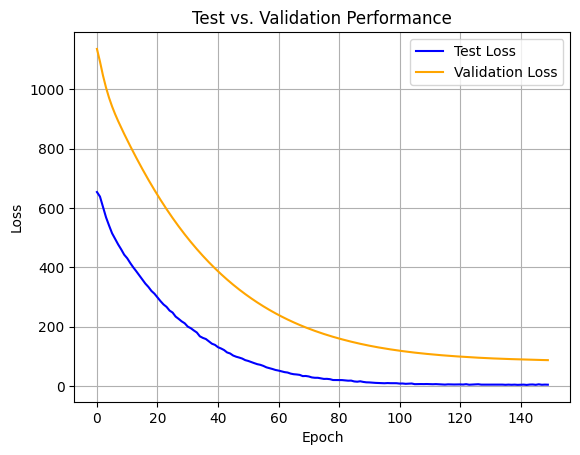

Train indices from 0 to 379 and validation indices from 380 to 567
Epoch [1/150], Loss: 36.8061, Validation Loss: 266.3176
Epoch [2/150], Loss: 35.5341, Validation Loss: 256.2475
Epoch [3/150], Loss: 32.1546, Validation Loss: 246.4605
Epoch [4/150], Loss: 30.0837, Validation Loss: 237.3171
Epoch [5/150], Loss: 28.7061, Validation Loss: 228.7933
Epoch [6/150], Loss: 28.5068, Validation Loss: 220.9426
Epoch [7/150], Loss: 27.3858, Validation Loss: 213.7492
Epoch [8/150], Loss: 25.6924, Validation Loss: 207.1443
Epoch [9/150], Loss: 23.6401, Validation Loss: 201.1901
Epoch [10/150], Loss: 25.8983, Validation Loss: 195.9857
Epoch [11/150], Loss: 24.5095, Validation Loss: 191.3697
Epoch [12/150], Loss: 23.6609, Validation Loss: 187.3039
Epoch [13/150], Loss: 24.3254, Validation Loss: 183.7478
Epoch [14/150], Loss: 23.6908, Validation Loss: 180.6923
Epoch [15/150], Loss: 22.9469, Validation Loss: 178.0107
Epoch [16/150], Loss: 23.9384, Validation Loss: 175.7293
Epoch [17/150], Loss: 22.4298,

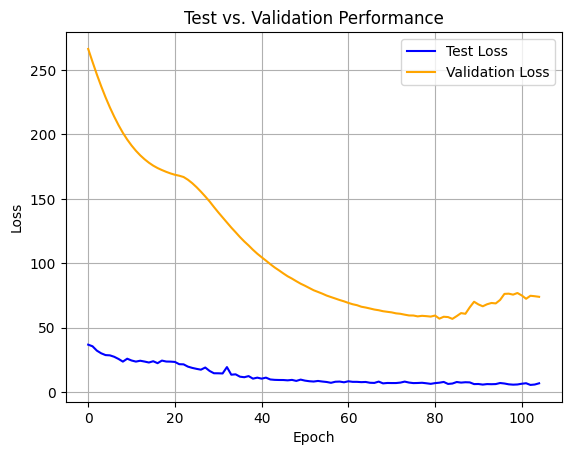

Train indices from 0 to 567 and validation indices from 568 to 755
Epoch [1/150], Loss: 477.2635, Validation Loss: 234.5414
Epoch [2/150], Loss: 318.3494, Validation Loss: 238.7144
Epoch [3/150], Loss: 248.4759, Validation Loss: 236.8156
Epoch [4/150], Loss: 191.0012, Validation Loss: 229.9792
Epoch [5/150], Loss: 159.9512, Validation Loss: 220.7371
Epoch [6/150], Loss: 111.0975, Validation Loss: 210.3432
Epoch [7/150], Loss: 71.8089, Validation Loss: 199.9092
Epoch [8/150], Loss: 48.4210, Validation Loss: 190.1086
Epoch [9/150], Loss: 27.2172, Validation Loss: 181.2222
Epoch [10/150], Loss: 21.1718, Validation Loss: 173.6335
Epoch [11/150], Loss: 18.5888, Validation Loss: 167.4282
Epoch [12/150], Loss: 19.1427, Validation Loss: 162.5409
Epoch [13/150], Loss: 19.1942, Validation Loss: 158.5583
Epoch [14/150], Loss: 17.7662, Validation Loss: 155.2506
Epoch [15/150], Loss: 17.4788, Validation Loss: 152.4181
Epoch [16/150], Loss: 17.7440, Validation Loss: 149.8100
Epoch [17/150], Loss: 16

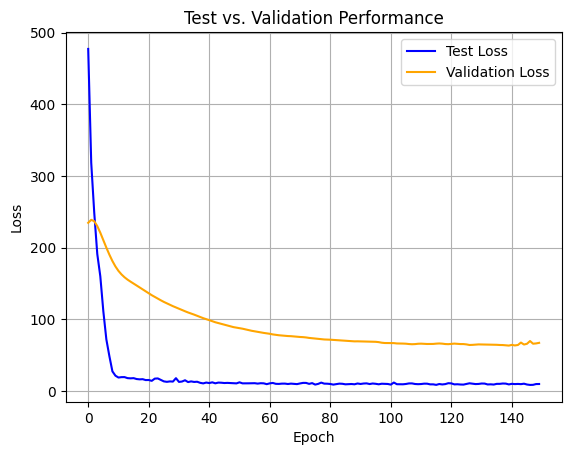

Train indices from 0 to 755 and validation indices from 756 to 943
Epoch [1/150], Loss: 49.9424, Validation Loss: 53.1331
Epoch [2/150], Loss: 36.6102, Validation Loss: 43.3718
Epoch [3/150], Loss: 38.6109, Validation Loss: 42.5061
Epoch [4/150], Loss: 36.4844, Validation Loss: 43.3872
Epoch [5/150], Loss: 42.2977, Validation Loss: 41.7474
Epoch [6/150], Loss: 80.2017, Validation Loss: 38.1676
Epoch [7/150], Loss: 58.2051, Validation Loss: 34.8160
Epoch [8/150], Loss: 59.7999, Validation Loss: 33.1437
Epoch [9/150], Loss: 47.7601, Validation Loss: 31.2077
Epoch [10/150], Loss: 79.3472, Validation Loss: 30.4543
Epoch [11/150], Loss: 106.6345, Validation Loss: 30.2784
Epoch [12/150], Loss: 74.4425, Validation Loss: 29.2021
Epoch [13/150], Loss: 56.7334, Validation Loss: 27.5297
Epoch [14/150], Loss: 32.7441, Validation Loss: 26.3634
Epoch [15/150], Loss: 33.0833, Validation Loss: 25.1837
Epoch [16/150], Loss: 41.8378, Validation Loss: 23.8969
Epoch [17/150], Loss: 34.1729, Validation Los

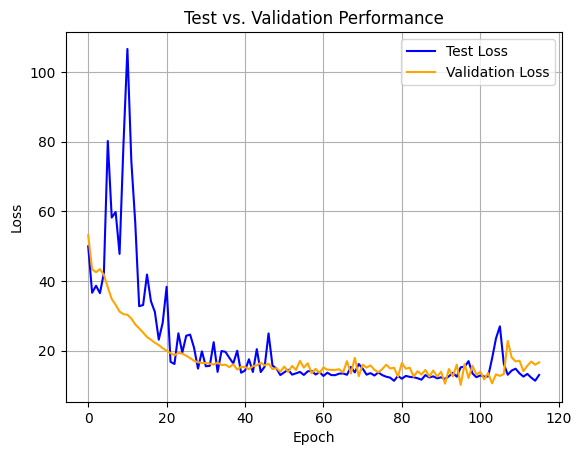

Train indices from 0 to 943 and validation indices from 944 to 1131
Epoch [1/150], Loss: 17.2249, Validation Loss: 535.5880
Epoch [2/150], Loss: 17.1499, Validation Loss: 586.0317
Epoch [3/150], Loss: 15.1156, Validation Loss: 541.1672
Epoch [4/150], Loss: 13.5677, Validation Loss: 577.9679
Epoch [5/150], Loss: 14.6637, Validation Loss: 580.4285
Epoch [6/150], Loss: 15.9786, Validation Loss: 623.5895
Epoch [7/150], Loss: 15.2346, Validation Loss: 553.1894
Epoch [8/150], Loss: 17.1851, Validation Loss: 644.6483
Epoch [9/150], Loss: 18.1451, Validation Loss: 554.1229
Epoch [10/150], Loss: 18.5881, Validation Loss: 647.9523
Epoch [11/150], Loss: 15.4240, Validation Loss: 582.4823
Epoch [12/150], Loss: 15.6694, Validation Loss: 648.2564
Epoch [13/150], Loss: 14.8487, Validation Loss: 624.0199
Epoch [14/150], Loss: 15.6223, Validation Loss: 619.7021
Epoch [15/150], Loss: 13.3532, Validation Loss: 630.2317
Epoch [16/150], Loss: 13.7035, Validation Loss: 617.5137
Epoch [17/150], Loss: 13.4769

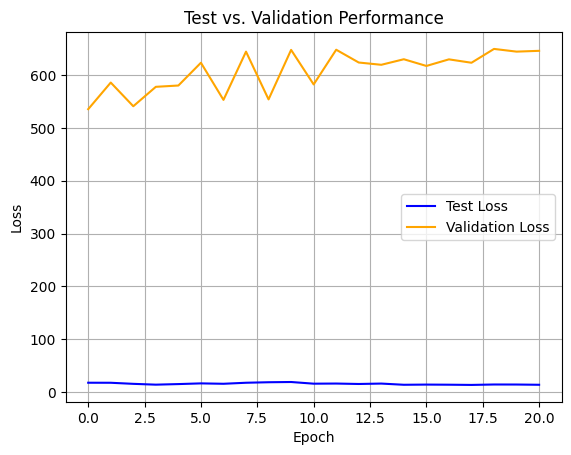

Train indices from 0 to 1131 and validation indices from 1132 to 1319
Epoch [1/150], Loss: 179.2561, Validation Loss: 5741.8075
Epoch [2/150], Loss: 143.9708, Validation Loss: 5523.4808
Epoch [3/150], Loss: 123.5468, Validation Loss: 5516.0135
Epoch [4/150], Loss: 105.0886, Validation Loss: 5329.9187
Epoch [5/150], Loss: 100.4962, Validation Loss: 5118.6782
Epoch [6/150], Loss: 98.2500, Validation Loss: 5057.6188
Epoch [7/150], Loss: 112.0158, Validation Loss: 5047.8296
Epoch [8/150], Loss: 99.9798, Validation Loss: 4951.3984
Epoch [9/150], Loss: 94.0633, Validation Loss: 4896.3363
Epoch [10/150], Loss: 93.3736, Validation Loss: 4853.7883
Epoch [11/150], Loss: 94.8697, Validation Loss: 4775.9814
Epoch [12/150], Loss: 93.7057, Validation Loss: 4762.4871
Epoch [13/150], Loss: 90.2237, Validation Loss: 4662.6948
Epoch [14/150], Loss: 96.7391, Validation Loss: 4672.3911
Epoch [15/150], Loss: 81.8438, Validation Loss: 4554.9829
Epoch [16/150], Loss: 82.9238, Validation Loss: 4585.4757
Epoch

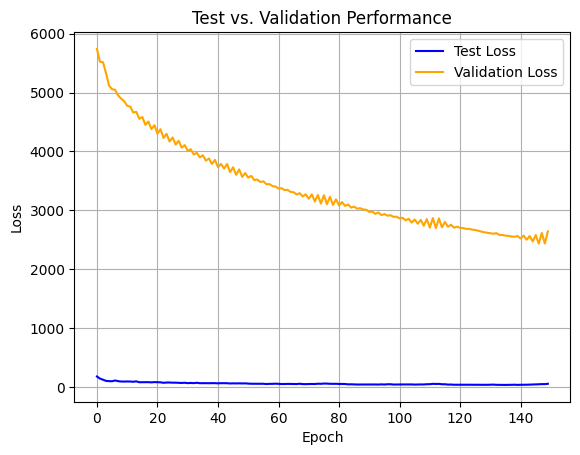

Train indices from 0 to 1319 and validation indices from 1320 to 1507
Epoch [1/150], Loss: 533.6515, Validation Loss: 5280.4170
Epoch [2/150], Loss: 556.4559, Validation Loss: 5091.2539
Epoch [3/150], Loss: 510.8980, Validation Loss: 5114.2881
Epoch [4/150], Loss: 479.2503, Validation Loss: 5004.6156
Epoch [5/150], Loss: 459.7065, Validation Loss: 4871.4204
Epoch [6/150], Loss: 432.8485, Validation Loss: 4734.0919
Epoch [7/150], Loss: 424.3827, Validation Loss: 4595.2675
Epoch [8/150], Loss: 398.2197, Validation Loss: 4488.5220
Epoch [9/150], Loss: 399.6434, Validation Loss: 4345.6292
Epoch [10/150], Loss: 388.6726, Validation Loss: 4264.2842
Epoch [11/150], Loss: 388.5827, Validation Loss: 4157.1445
Epoch [12/150], Loss: 368.3264, Validation Loss: 4083.9116
Epoch [13/150], Loss: 360.1795, Validation Loss: 3962.3298
Epoch [14/150], Loss: 348.1069, Validation Loss: 3902.9224
Epoch [15/150], Loss: 342.4065, Validation Loss: 3784.4072
Epoch [16/150], Loss: 347.7229, Validation Loss: 3741.

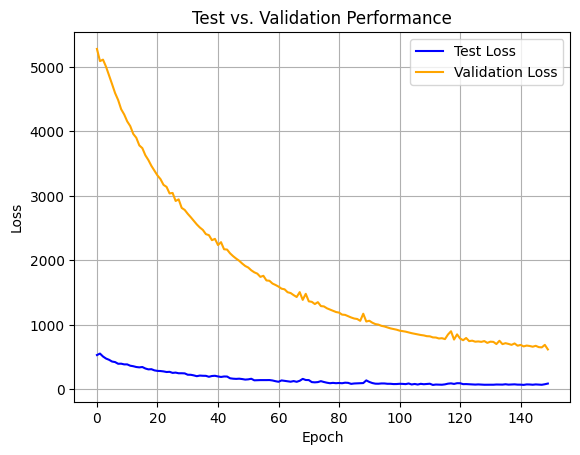

Train indices from 0 to 1507 and validation indices from 1508 to 1695
Epoch [1/150], Loss: 567.3917, Validation Loss: 2740.7573
Epoch [2/150], Loss: 256.6629, Validation Loss: 1908.0902
Epoch [3/150], Loss: 266.3809, Validation Loss: 2039.3636
Epoch [4/150], Loss: 238.5586, Validation Loss: 1965.8950
Epoch [5/150], Loss: 210.4911, Validation Loss: 1741.9800
Epoch [6/150], Loss: 212.8278, Validation Loss: 1759.8422
Epoch [7/150], Loss: 195.2613, Validation Loss: 1599.2948
Epoch [8/150], Loss: 183.8566, Validation Loss: 1669.5651
Epoch [9/150], Loss: 173.6713, Validation Loss: 1480.8224
Epoch [10/150], Loss: 182.9253, Validation Loss: 1596.0450
Epoch [11/150], Loss: 175.7865, Validation Loss: 1392.5035
Epoch [12/150], Loss: 167.7130, Validation Loss: 1511.5521
Epoch [13/150], Loss: 159.7426, Validation Loss: 1311.1842
Epoch [14/150], Loss: 170.3405, Validation Loss: 1473.1249
Epoch [15/150], Loss: 157.1093, Validation Loss: 1242.8741
Epoch [16/150], Loss: 161.8156, Validation Loss: 1383.

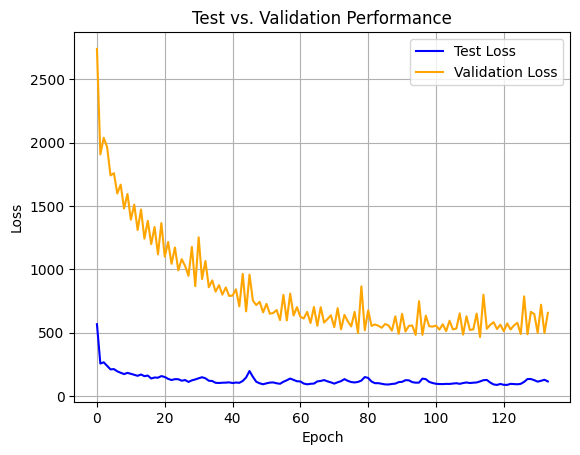

In [15]:
from util import training, ElmanRNN, JordanRNN

from sklearn.preprocessing import RobustScaler

jordan_model_h32 = JordanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, state_size=32, dropout=0.1)

apple_jordan_h32_results = training(model=jordan_model_h32,
                             data=preprocessed_train,
                             batch_size=128,
                             optimizer_learning_rate=0.005,
                             optimizer_weight_decay=1e-5,
                             target_feature_name='ClosingPrice',
                             model_name='JordanRNN_h32_apple',
                             splits=8,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=150)

In [16]:
pickle.dump(apple_jordan_h32_results, open('../pickles/apple-jordan-h32-results.pkl', 'wb'))
pickle.dump(apple_elman_h32_results, open('../pickles/apple-elman-h32-results.pkl', 'wb'))

Number of years: 4


/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


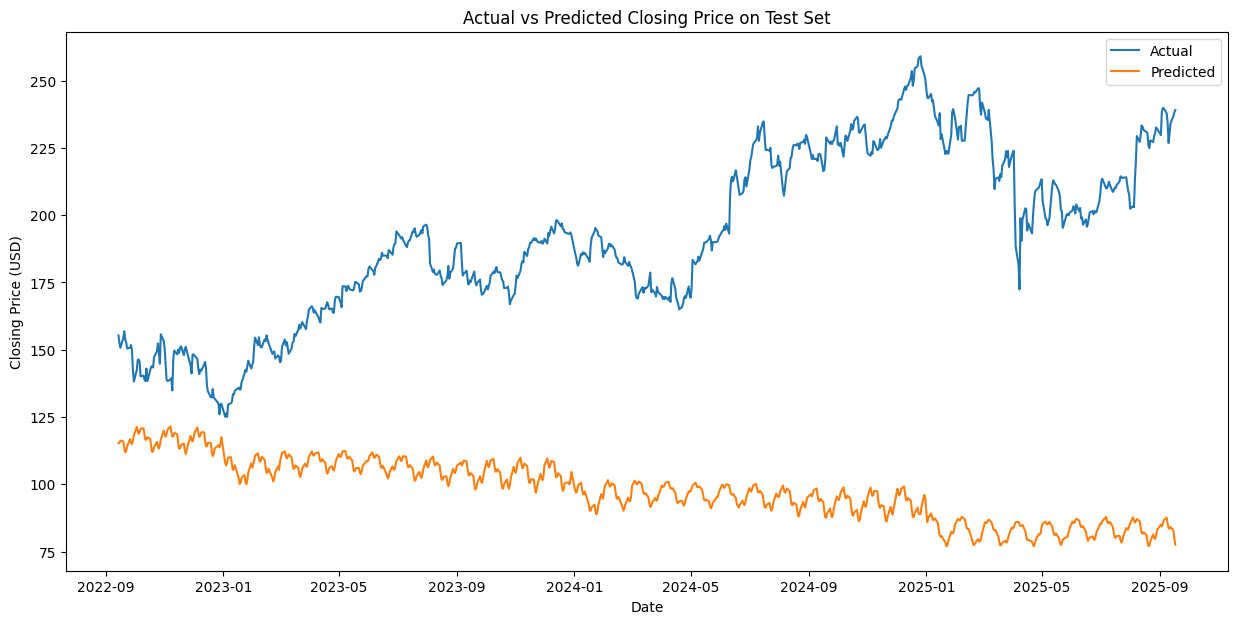

In [17]:
from util import get_predictions

r1 = get_predictions(raw_test=raw_test,
                preprocessed_test=preprocess(raw_test.copy()),
                results=apple_elman_h32_results,
                target_feature_name='ClosingPrice',
                model_name='ElmanRNN H32 Apple', show_plot=True,
                xlabel='Date',
                ylabel='Closing Price (USD)',
                title='Actual vs Predicted Closing Price on Test Set',
                save_path='../images/apple-elman-h32-actual-vs-predicted.pdf'
                )

Number of years: 4


/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


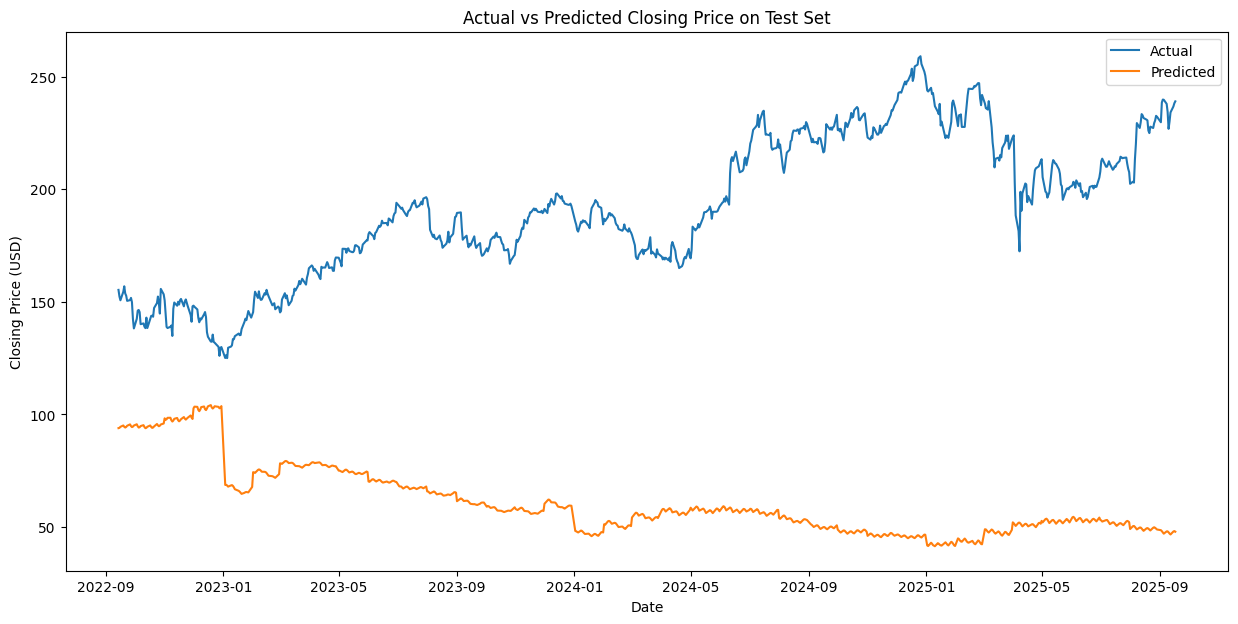

In [18]:
r2 = get_predictions(raw_test=raw_test,
                preprocessed_test=preprocess(raw_test.copy()),
                results=apple_jordan_h32_results,
                target_feature_name='ClosingPrice',
                model_name='JordanRNN H32 Apple', show_plot=True,
                xlabel='Date',
                ylabel='Closing Price (USD)',
                title='Actual vs Predicted Closing Price on Test Set',
                save_path='../images/apple-jordan-h32-actual-vs-predicted.pdf'
                )

In [25]:
results = pd.concat([r1, r2], axis=0)
results.round(2).to_csv('../csv-descriptions/apple-rnn-results-raw.csv', index=False)